### 0. Import config

In [1]:
from config import dataset_config
from config import model_config
from config import train_config
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## 1. Dataset

This implmentation uses VOC dataset instead of COCO

### 1.1 Donwload the dataset

In [2]:
# === Download and extract datasets ===
from dataset import VOCDataset, download_and_extract, move_voc
import os
os.makedirs(dataset_config['BASE_DIR'], exist_ok=True)
download_and_extract(dataset_config['VOC2007_TRAINVAL_URL'], dataset_config['BASE_DIR'])
move_voc("VOC2007", "VOC2007")

download_and_extract(dataset_config['VOC2007_TEST_URL'], dataset_config['BASE_DIR'])
move_voc("VOC2007", "VOC2007-test")

download_and_extract(dataset_config['VOC2012_URL'], dataset_config['BASE_DIR'])
move_voc("VOC2012", "VOC2012")

# Cleanup VOCdevkit folder
vocdevkit_path = os.path.join(dataset_config['BASE_DIR'], "VOCdevkit")
if os.path.exists(vocdevkit_path) and not os.listdir(vocdevkit_path):
    os.rmdir(vocdevkit_path)

VOCtrainval_06-Nov-2007.tar already exists, skipping download.
Extracting VOCtrainval_06-Nov-2007.tar...
Extracted to data
VOC2007 already exists, skipping move.
VOCtest_06-Nov-2007.tar already exists, skipping download.
Extracting VOCtest_06-Nov-2007.tar...
Extracted to data
VOC2007-test already exists, skipping move.
VOCtrainval_11-May-2012.tar already exists, skipping download.
Extracting VOCtrainval_11-May-2012.tar...
Extracted to data
VOC2012 already exists, skipping move.


### 1.2 Prepare dataset and dataloader

In [13]:
from dataset import VOCDataset
from torch.utils.data import DataLoader

def collate_function(data):
    return tuple(zip(*data))

train_dataset = VOCDataset('train',
                    im_sets=dataset_config['train_im_sets'],
                    im_size=dataset_config['im_size'])

test_dataset = VOCDataset('test',
                    im_sets=dataset_config['test_im_sets'],
                    im_size=dataset_config['im_size'])

train_dataloader = DataLoader(train_dataset,
                            batch_size=train_config['batch_size'],
                            shuffle=True,
                            collate_fn=collate_function,
                            #num_workers=dataset_config['num_workers'],
                            pin_memory=True
                            )

test_dataloader = DataLoader(test_dataset,
                            batch_size=train_config['batch_size'],
                            shuffle=True,
                            collate_fn=collate_function,
                            #num_workers=dataset_config['num_workers'],
                            pin_memory=True
                            )

print(f"Train data size: {len(train_dataset)}, Test data size: {len(test_dataset)}")
print(f"Train dataloader size: {len(train_dataloader)}, Test dataloader size: {len(test_dataloader)}")

{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}
Total 16536 images found
{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}
Total 4945 images found
Train data size: 16536, Test data size: 4945
Train dataloader size: 276, Test dataloader size: 83


## 2. Model Architecture

### 2.1 Creating Embeddings: Backbone + Positional embedding


In [3]:
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
# Backbone of DETR
class Backbone(nn.Module):
    def __init__(self,
                 backbone_dim=model_config['backbone_dim'],
                 backbone_model=model_config['backbone_model'],
                 model_dim=model_config['model_dim']):
        super().__init__()
        # Load the pre-trained resnet50 model without final FC layer and tracking gradients
        if backbone_model == 50:
            resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT, norm_layer=torchvision.ops.FrozenBatchNorm2d)
            # Remove the final fully connected layer
        elif backbone_model == 101:
            resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT, norm_layer=torchvision.ops.FrozenBatchNorm2d)
            # Remove the final fully connected layer

        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        if model_config['freeze_backbone']:
            for param in self.resnet.parameters():
                param.requires_grad = False


        self.embed_proj = nn.Conv2d(in_channels=backbone_dim,
                                   out_channels=model_dim,
                                   kernel_size=1)


    def forward(self, x): 
        # x is the initial batch input (B, 3, H ,W)
        x = self.resnet(x) # (B, 2048, H', W')
        x = self.embed_proj(x) # (B, embed_dim, H', W')
        x = x.permute(0, 2, 3, 1) # (B, H', W', embed_dim)
        x = x.flatten(1, 2)  # (B, H'*W', embed_dim)
        return x


In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, model_dim=model_config['model_dim']):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(max_len, model_dim))  # (max_len, D)

    def forward(self, x):
        # x: (B, N, D)
        B, N, D = x.size()
        return self.pe[:N].unsqueeze(0).repeat(B, 1, 1)  # (B, N, D)

### 2.2 Encoder

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 model_dim=model_config['model_dim'],
                 encoder_heads=model_config['encoder_heads'],
                 mlp_inner_dim=model_config['mlp_inner_dim']):
        super().__init__()
        # Attention layer
        self.self_attn = nn.MultiheadAttention(model_dim, encoder_heads)
        self.norm_attn = nn.LayerNorm(model_dim)

        # MLP layer
        self.linear1 = nn.Linear(model_dim, mlp_inner_dim)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(mlp_inner_dim, model_dim)
        self.norm_mlp = nn.LayerNorm(model_dim)

    def forward(self, features, pos_enc):
        # features, pos_enc: (B, N, D)
        
        # Attention
        q = (features + pos_enc).transpose(0, 1)  # Add positional encoding only to q and k
        k = (features + pos_enc).transpose(0, 1)  
        v = features.transpose(0, 1)
        attn_output, _ = self.self_attn(q, k, v) # (N, B, D)
        attn_output = features +  attn_output.transpose(0, 1) # (B, N ,D)
        attn_output = self.norm_attn(attn_output)

        # MLP
        ff = self.linear2(self.dropout(torch.relu(self.linear1(attn_output)))) # FC1 -> ReLU -> Dropout -> FC2 
        encoder_output = self.norm_mlp(attn_output + ff)
        return encoder_output



class Encoder(nn.Module):
    def __init__(self,
                 model_dim=model_config['model_dim'],
                 encoder_heads=model_config['encoder_heads'],
                 encoder_layers=model_config['encoder_layers']):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(model_dim, encoder_heads) for _ in range(encoder_layers)])

    def forward(self, features, pos_enc):
        for layer in self.layers:
            src = layer(features, pos_enc) # The positional encoder is added before every attention layer.
        return src

### 2.3 Decoder

In [6]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 model_dim=model_config['model_dim'],
                 decoder_heads=model_config['decoder_heads'],
                 mlp_inner_dim=model_config['mlp_inner_dim']):
        super().__init__()

        # Self Attention
        self.self_attn = nn.MultiheadAttention(model_dim, decoder_heads)
        self.norm_self_attn = nn.LayerNorm(model_dim)
        
        # Cross Attention
        self.cross_attn = nn.MultiheadAttention(model_dim, decoder_heads)
        self.norm_cross_attn = nn.LayerNorm(model_dim)
        
        # MLP
        self.linear1 = nn.Linear(model_dim, mlp_inner_dim)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(mlp_inner_dim, model_dim)
        self.norm_mlp = nn.LayerNorm(model_dim)

    def forward(self, tgt, memory, pos_enc, query_pos):
        # Self-attention
        q = (tgt + query_pos).transpose(0, 1) # query positional encoding is only added to q and k
        k = (tgt + query_pos).transpose(0, 1) # (N, B, D)
        v = tgt.transpose(0, 1) 
        self_attn_output, _ = self.self_attn(q, k, v) # (N, B, D)
        tgt = self.norm_self_attn(tgt + self_attn_output.transpose(0, 1)) # (B, N ,D)

        # Cross-attention
        q = (tgt + query_pos).transpose(0, 1)         # the query positional encoding is added to object queries
        k = (memory + pos_enc).transpose(0, 1) # the positional encoding is added to the encoder's output
        v = memory.transpose(0, 1) # (N, B ,D)
        cross_attn_output, cross_attn = self.cross_attn(q, k, v) # (N, B ,D)
        tgt = self.norm_cross_attn(tgt + cross_attn_output.transpose(0, 1)) # (B, N ,D)

        # MLP
        ff = self.linear2(self.dropout(torch.relu(self.linear1(tgt))))
        tgt = self.norm_mlp(tgt + ff) # (B, N, D)
        return tgt, cross_attn


class Decoder(nn.Module):
    def __init__(self,
                 model_dim=model_config['model_dim'],
                 decoder_heads=model_config['decoder_heads'],
                 decoder_layers=model_config['decoder_layers']):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(model_dim, decoder_heads) for _ in range(decoder_layers)])

        self.output_norm = nn.LayerNorm(model_dim)
        
    def forward(self, tgt, memory, pos_enc, query_pos):
        outputs = []
        cross_attn_weights = []
        for layer in self.layers:
            tgt, decoder_cross_attn = layer(tgt, memory, pos_enc, query_pos)
            cross_attn_weights.append(decoder_cross_attn)
            outputs.append(self.output_norm(tgt))

        output = torch.stack(outputs)    
        return output, torch.stack(cross_attn_weights)

### 2.4 Full DETR Class

In [7]:
class DETR(nn.Module):
    def __init__(self,
                 model_dim=model_config['model_dim'],
                 num_queries=model_config['num_queries'],
                 num_classes=dataset_config['num_classes'],
                 max_len=5000):
        super().__init__()

        self.backbone = Backbone()

        self.encoder = Encoder()
        self.decoder = Decoder()

        # Learnable positional encoding for feature embeddings and object queries
        self.pos_enc = PositionalEncoding(max_len, model_dim)  # Learnable positional encoding

        self.query_embed = nn.Embedding(num_queries, model_dim)  # Learnable queries

        # Prediction
        self.class_mlp = nn.Linear(model_dim, num_classes)
        self.bbox_mlp = nn.Sequential(nn.Linear(model_dim, model_dim),
                                        nn.ReLU(),
                                        nn.Linear(model_dim, model_dim),
                                        nn.ReLU(),
                                        nn.Linear(model_dim, 4))

    def forward(self, x):
        # x: (B, 3, H, W)
        B = x.size(0)

        # Backbone
        features = self.backbone(x)                 # (B, N, D)

        pos_enc = self.pos_enc(features)            # (B, N, D) ← now learnable

        # Encoder
        memory = self.encoder(features, pos_enc)    # (B, N, D)

        query_pos = self.query_embed.weight.unsqueeze(0).repeat(B, 1, 1)  # (B, num_queries, D)
        tgt = torch.zeros_like(query_pos)

        # Decoder
        hs, _ = self.decoder(tgt, memory, pos_enc, query_pos)  # (num_decoders, B, num_queries, D)

        # Prediction
        pred_logits = self.class_mlp(hs)  # (num_decoders, B, num_queries, num_classes)
        pred_bboxes = self.bbox_mlp(hs).sigmoid()  # (num_decoders, B, num_queries, 4)

        return {'pred_logits': pred_logits, 'pred_boxes': pred_bboxes}


Test the defined DETR

In [8]:
test = torch.randn((16, 3, 640, 640))

model_detr = DETR().to(device)
test_output = model_detr(test.to(device))
print(test_output['pred_logits'].shape)  # Should be (num_decoders, B, num_queries, num_classes)
print(test_output['pred_boxes'].shape)  # Should be (num_decoders, B, num_queries, 4)

torch.Size([4, 16, 25, 21])
torch.Size([4, 16, 25, 4])


In [9]:
from torchinfo import summary

summary(model=model_detr, 
        input_size=(train_config['batch_size'], 3, dataset_config['im_size'], dataset_config['im_size']),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
DETR (DETR)                                             [60, 3, 640, 640]    [4, 60, 25, 4]       6,400                Partial
├─Backbone (backbone)                                   [60, 3, 640, 640]    [60, 400, 256]       --                   Partial
│    └─Sequential (resnet)                              [60, 3, 640, 640]    [60, 2048, 20, 20]   --                   False
│    │    └─Conv2d (0)                                  [60, 3, 640, 640]    [60, 64, 320, 320]   (9,408)              False
│    │    └─FrozenBatchNorm2d (1)                       [60, 64, 320, 320]   [60, 64, 320, 320]   --                   --
│    │    └─ReLU (2)                                    [60, 64, 320, 320]   [60, 64, 320, 320]   --                   --
│    │    └─MaxPool2d (3)                               [60, 64, 320, 320]   [60, 64, 160, 160]   --                   --
│

### 3 Loss

DETRLoss class consists of two different methods: Hungarian matching and loss calculation

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from scipy.optimize import linear_sum_assignment
from collections import defaultdict

class DETRLoss(nn.Module):
    def __init__(self,
                 num_classes=dataset_config['num_classes'],
                 decoder_layers=model_config['decoder_layers'],
                 num_queries=model_config['num_queries'],
                 cls_cost_weight=model_config['cls_cost_weight'],
                 l1_cost_weight=model_config['l1_cost_weight'],
                 giou_cost_weight=model_config['giou_cost_weight'],
                 bg_class_idx=dataset_config['bg_class_idx'],
                 bg_class_weight=model_config['bg_class_weight'],
                 nms_threshold=model_config['nms_threshold']):
        super().__init__()
        self.num_classes = num_classes
        self.num_decoder_layers = decoder_layers
        self.num_queries = num_queries
        self.cls_cost_weight = cls_cost_weight
        self.l1_cost_weight = l1_cost_weight
        self.giou_cost_weight = giou_cost_weight
        self.bg_class_idx = bg_class_idx
        self.bg_class_weight = bg_class_weight
        self.nms_threshold = nms_threshold

    def compute_hungarian_matching(self, pred_logits, pred_boxes, targets):
        # pred_logits = [B, num_queries, num_classes]

        batch_size = pred_logits.shape[0]
        num_queries = pred_logits.shape[1]

        class_prob = pred_logits.reshape(-1, self.num_classes).softmax(dim=-1)
        pred_boxes = pred_boxes.reshape(-1, 4)
        # class_prob, pred_boxes = (B*num_queries, num_classes), (B*num_queries, 4)

        target_labels = torch.cat([t['labels'] for t in targets])
        target_boxes = torch.cat([t['boxes'] for t in targets])
        # e.g., two objs [1, 11] and an obj [5] -> target_labels = torch.tensor([1,11,5])
        # target_boxes = torch.tensor([torch.size(4),torch.size(4), torch.size(4)]       

        ## Classification cost
        cost_classification = -class_prob[:, target_labels]
        # cost_classifi = (B*num_queries, total_num_objs_in_batch). if case above -> (B*num_queries,3)

        # To calculate the GIoU, need to transform  cx,cy,w,h into 'x,y,x,y'
        pred_boxes_xyxy = torchvision.ops.box_convert(pred_boxes, 'cxcywh', 'xyxy')
        

        ## Bbox cost (L1 + GIoU) 
        # L1 cost
        cost_l1 = torch.cdist(pred_boxes_xyxy, target_boxes, p=1)
        # cost_l1 = (B*num_queries, total_num_objs_in_batch)

        # GIoU cost
        cost_giou = -torchvision.ops.generalized_box_iou(pred_boxes_xyxy, target_boxes)
        # cost_giou = (B*num_queries, total_num_objs_in_batch)

        ### Gross loss = classification cost + L1 cost + GIoU cost
        total_cost = (self.cls_cost_weight * cost_classification +
                      self.l1_cost_weight * cost_l1 +
                      self.giou_cost_weight * cost_giou)

        total_cost = total_cost.reshape(batch_size, self.num_queries, -1).cpu()
        # total_cost = (B, num_queries, total_num_objs_in_batch)

        num_targets_per_image = [len(t['labels']) for t in targets]
        # e.g., num_targets_per_image = [2, 1]
        total_cost_per_image = total_cost.split(num_targets_per_image, dim=-1)
        # e.g., total_cost_per_image[0] = (B, num_queries, 2) <- 2 GTs from image 0
        # e.g., total_cost_per_image[1] = (B, num_queries, 1) <- 1 GT from image 1

        match_indices = []
        # This function gives the best matchings between predicted queries and GTs, 
        # minimizing the total cost:
        # pred_inds: indices into the 25 queries
        # tgt_inds: indices into the N_b GTs
        for b in range(batch_size):
            pred_inds, tgt_inds = linear_sum_assignment(total_cost_per_image[b][b])
            # picking the b-th image among the batch of B=2, from the b-th cost tensor.
            match_indices.append((
                torch.as_tensor(pred_inds, dtype=torch.int64),
                torch.as_tensor(tgt_inds, dtype=torch.int64)
            ))
            # e.g., match_indices = [
            #       (tensor([ 5, 13]), tensor([0, 1])),  # image 0: query 5→GT 0, query 13→GT 1
            #       (tensor([2]), tensor([0]))]           # image 1: query 2→GT 0
        return match_indices

    def compute_losses(self, pred_logits, pred_boxes, targets, match_indices):
        batch_size = pred_logits.shape[0]
        losses = defaultdict(list)
        classification_losses = []  # <<< ADDED
        bbox_losses = []            # <<< ADDED
        bbox_giou_losses = []       # <<< ADDED

        for b in range(batch_size):
            pred_idx, tgt_idx = match_indices[b]
            # e.g., ([3, 7], [0, 1])

            # Create a tensor of shape (num_queries,) filled with the background class index.
            # Used to label all unassigned queries as background by default.
            target_classes = torch.full((self.num_queries,), self.bg_class_idx,
                                        dtype=torch.int64, device=pred_logits.device)
            # target_classes = [0]*num_queries

            # For matched queries, update the target class with the corresponding GT label.
            target_classes[pred_idx] = targets[b]['labels'][tgt_idx]
            # e.g., targets[b]['labels'] = tensor([5, 2])
            # target_classes = [0, 0, 0, 5, 0, 0, 0 ,2, ... 0]
            #              idx  0  1  2  3  4  5  6  7  ... 24

            # Define the class weights for cross-entropy.
            cls_weights = torch.ones(self.num_classes, device=pred_logits.device)
            cls_weights[self.bg_class_idx] = self.bg_class_weight
            #cls_weights = [0.1, 1, 1, ...,  1],
            #            idx  0   1  2  .... 20

            # (1) Classification loss --> return scalar
            #loss_cls = F.cross_entropy(pred_logits[b], target_classes, weight=cls_weights)
            # Don't reduce the loss here, will be done later.
            loss_cls = F.cross_entropy(pred_logits[b], target_classes, weight=cls_weights, reduction='none')  # <<< CHANGED
            classification_losses.append(loss_cls)  # <<< CHANGED

            matched_pred_boxes = pred_boxes[b][pred_idx]
            target_boxes = targets[b]['boxes'][tgt_idx]
            #matched_pred_boxes, target_boxes = [num_matched_queries, 4] 

            # Convert predicted boxes from cx,cy,w,h to x1,y1,x2,y2) for GIoU computation.
            pred_xyxy = torchvision.ops.box_convert(matched_pred_boxes, 'cxcywh', 'xyxy')

            # (2) Bboxes loss --> return scalar
            loss_bbox = F.l1_loss(pred_xyxy, target_boxes, reduction='none').sum(dim=1)  # <<< CHANGED
            loss_giou = torchvision.ops.generalized_box_iou_loss(pred_xyxy, target_boxes, reduction='none')  # <<< CHANGED
            #loss_bbox = F.l1_loss(pred_xyxy, target_boxes, reduction='none').sum() / matched_pred_boxes.shape[0]
            #loss_giou = torchvision.ops.generalized_box_iou_loss(pred_xyxy, target_boxes).sum() / matched_pred_boxes.shape[0]

            bbox_losses.append(loss_bbox)
            bbox_giou_losses.append(loss_giou)
            #bbox_loss = (loss_bbox.sum(dim=1) + loss_giou)  # <<< CHANGED
            #bbox_losses.append(bbox_loss)  # <<< CHANGED

            # Multiply each weight
            #losses['classification'].append(loss_cls * self.cls_cost_weight)
            #losses['bbox_regression'].append(loss_bbox * self.l1_cost_weight + loss_giou * self.giou_cost_weight)

        # Concatenate all per-image losses and average over batch
        all_cls_loss = torch.cat(classification_losses).mean()
        all_l1_loss = torch.cat(bbox_losses).mean()
        all_giou_loss = torch.cat(bbox_giou_losses).mean()

        los_cls = all_cls_loss * self.cls_cost_weight
        los_bbox = all_l1_loss * self.l1_cost_weight + all_giou_loss * self.giou_cost_weight
        
        return los_cls, los_bbox

    def forward(self, pred_classes, pred_bboxes, targets, training=True, score_thresh=0.0, use_nms=False):
        losses = defaultdict(list)
        detections = []
        detr_output = {}

        if training:
            for decoder_idx in range(self.num_decoder_layers):
                cls_out = pred_classes[decoder_idx]
                box_out = pred_bboxes[decoder_idx]

                with torch.no_grad():
                    match_indices = self.compute_hungarian_matching(cls_out, box_out, targets)

                loss_cls, loss_bbox = self.compute_losses(cls_out, box_out, targets, match_indices)
                losses['classification'].append(loss_cls)
                losses['bbox_regression'].append(loss_bbox)
            # Average losses across all decoder layers


            detr_output['loss'] = losses

        else:
            # From the final decoder
            cls_out = pred_classes[-1] 
            box_out = pred_bboxes[-1]
            # (B, num_queries, num_classes), (B, num_queries, 4)
            prob = F.softmax(cls_out, -1)

            # Delete the background class
            if self.bg_class_idx == 0:
                scores, labels = prob[..., 1:].max(-1)
                labels += 1
                # scores, labels = (B, num_queries)
            else:
                scores, labels = prob[..., :-1].max(-1)

            boxes = torchvision.ops.box_convert(box_out, 'cxcywh', 'xyxy')
            # boxes = (B, num_queries, 4)

            # Iterate through each image in the batch
            for b in range(boxes.shape[0]):
                score_b, label_b, box_b = scores[b], labels[b], boxes[b] # confidence, class, boxes
                # (num_queries,)
                keep = score_b >= score_thresh
                #e.g.,
                    # score_b = tensor([0.9, 0.1, 0.5, 0.7])
                    # score_thresh = 0.5
                    # keep = tensor([True, False, True, True])
                score_b, label_b, box_b = score_b[keep], label_b[keep], box_b[keep]
                # score_b  = tensor([0.9, 0.5, 0.7])  # kept

                if use_nms:
                    keep_nms = torchvision.ops.batched_nms(box_b, score_b, label_b, self.nms_threshold)
                    score_b, label_b, box_b = score_b[keep_nms], label_b[keep_nms], box_b[keep_nms]

                detections.append({"boxes": box_b, "scores": score_b, "labels": label_b})

            detr_output['detections'] = detections

        return detr_output


## 4. Training

### 4.1 Setup and training

In [11]:
from torch.optim.lr_scheduler import MultiStepLR
#from loss import DETRLoss

loss_fn = DETRLoss()
optimizer = torch.optim.AdamW(
    params=filter(lambda p: p.requires_grad, model_detr.parameters()),
    lr=train_config['lr'],
    weight_decay=1e-4)

lr_scheduler = MultiStepLR(optimizer,
                            train_config['lr_steps'],
                            gamma=0.1)

In [ ]:
import train
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_history = train.train(model=model_detr,
          dataloader=train_dataloader,
          device=device,
          loss_fn=loss_fn,
          optimizer=optimizer,
          scheduler=lr_scheduler,
          epochs=train_config['num_epochs'])


### 4.2 Learning curve

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_history['classification'], label='Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Class Loss')
plt.title('Loss History')
plt.legend()
plt.show()

plt.plot(loss_history['bbox_regression'], label='Bbox Regression Loss')
plt.xlabel('Epochs')
plt.ylabel('Bbox Loss')
plt.title('Localization Loss History')
plt.legend()
plt.show()

### 4.3 Visualization

The below visualize four inference results w.r.t
1) Image with GT bboxes
2) Image with predicted bboxes
3) Image with corresponding object queries (Cross attention results)

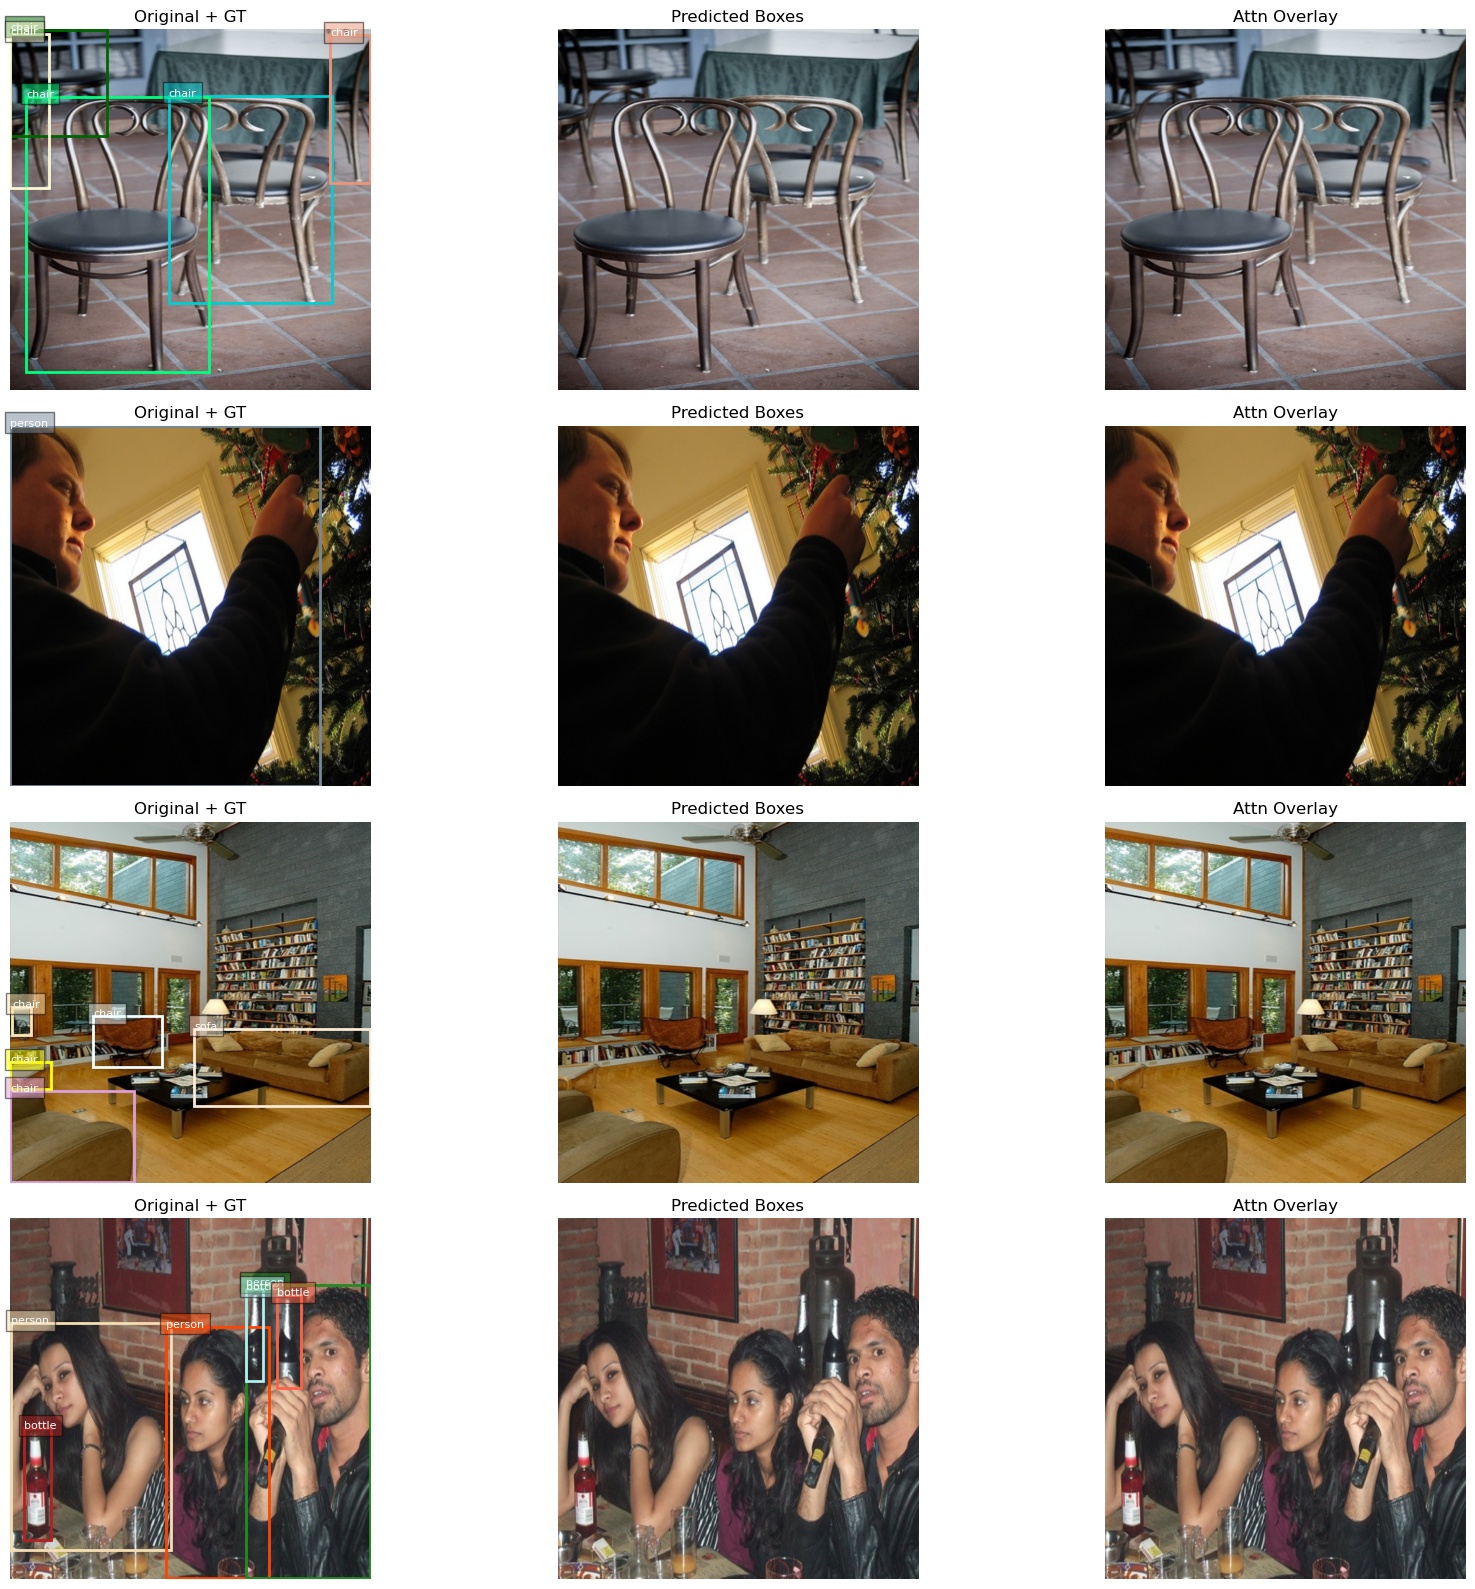

In [16]:
from visualization import visualize_detr_output

visualize_detr_output(
    model=model_detr,
    dataloader=test_dataloader,
    loss_fn=DETRLoss(),
    device=device,
    batch_size=4,
    score_thresh=0.7
)
